# Play Visualization Notebook

### Import Libraries

In [1]:
%matplotlib widget

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.patheffects as patheffects
from matplotlib.animation import FuncAnimation

### Import Data

In [3]:
def merge_input_output(
    df_input: pd.DataFrame,
    df_output: pd.DataFrame,
    label_col: str = "label",
    meta_cols=None,
) -> pd.DataFrame:
    """
    Merge pre-throw (input) and post-throw (output) tracking data.

    - Matches on ['game_id', 'play_id', 'nfl_id'].
    - Shifts output frame_id so it continues from the last input frame
      for each (game_id, play_id, nfl_id).
    - Adds a label label column (e.g. 'input' or 'output').
    - Optionally merges metadata columns from input onto output rows.

    Parameters
    ----------
    df_input : pd.DataFrame
        Pre-throw tracking data.
    df_output : pd.DataFrame
        Post-throw tracking data (frame_id usually restarts at 1).
    label_col : str, default "label"
        Name of the column indicating whether a row is from input or output.
    meta_cols : list of str or None
        Columns from df_input to copy onto df_output.
        If None, we'll infer as "all columns except the obvious
        time/position columns".

    Returns
    -------
    pd.DataFrame
        Combined DataFrame with continuous frame_id and a label label.
    """
    key_cols = ["game_id", "play_id", "nfl_id"]

    df_in = df_input.copy()
    df_out = df_output.copy()

    df_in[label_col] = "input"
    df_out[label_col] = "output"

    # ---- 1. Compute per-player offset = last input frame ----
    offsets = (
        df_in.groupby(key_cols)["frame_id"]
        .max()
        .rename("frame_offset")
        .reset_index()
    )

    # Attach offsets to output; if no input exists, offset = 0
    df_out = df_out.merge(offsets, on=key_cols, how="left")
    df_out["frame_offset"] = df_out["frame_offset"].fillna(0).astype(int)

    # Shift output frame_id
    df_out["frame_id"] = df_out["frame_id"] + df_out["frame_offset"]
    df_out = df_out.drop(columns=["frame_offset"])

    # ---- 2. Bring metadata from input onto output rows (optional but useful) ----
    if meta_cols is None:
        # infer metadata cols = everything in input that's not clearly
        # temporal/position and not a key
        exclude = set(key_cols + ["frame_id", "x", "y", "s", "a", "dir", "o", label_col])
        meta_cols = [c for c in df_in.columns if c not in exclude]

    if meta_cols:
        meta_df = df_in[key_cols + meta_cols].drop_duplicates(subset=key_cols)
        df_out = df_out.merge(meta_df, on=key_cols, how="left")

    # ---- 3. Combine input + output ----
    df_all = pd.concat([df_in, df_out], ignore_index=True, sort=False)

    # Sort nicely
    df_all = df_all.sort_values(key_cols + ["frame_id"]).reset_index(drop=True)

    return df_all

In [4]:
input_path  = os.path.join(os.getcwd(), "data", "input_2023_w01.csv")
output_path = os.path.join(os.getcwd(), "data", "output_2023_w01.csv")

df_in  = pd.read_csv(input_path)
df_out = pd.read_csv(output_path)

df_merged = merge_input_output(df_in, df_out)
df_merged.head()

,game_id,play_id,player_to_predict,nfl_id,frame_id,play_direction,absolute_yardline_number,player_name,player_height,player_weight,...,x,y,s,a,dir,o,num_frames_output,ball_land_x,ball_land_y,label
0,2023090700,101,False,43290,1,right,42,Jared Goff,6-4,223,...,37.36,30.07,0.00,0.00,65.42,95.98,21,63.259998,-0.22,input
1,2023090700,101,False,43290,2,right,42,Jared Goff,6-4,223,...,37.36,30.07,0.00,0.00,63.91,95.98,21,63.259998,-0.22,input
2,2023090700,101,False,43290,3,right,42,Jared Goff,6-4,223,...,37.35,30.07,0.00,0.00,53.83,95.98,21,63.259998,-0.22,input
3,2023090700,101,False,43290,4,right,42,Jared Goff,6-4,223,...,37.34,30.07,0.00,0.00,310.79,95.98,21,63.259998,-0.22,input
4,2023090700,101,False,43290,5,right,42,Jared Goff,6-4,223,...,37.33,30.07,0.06,1.37,271.81,96.80,21,63.259998,-0.22,input


In [5]:
play_info_cols = [
    "game_id", "play_id",
    "quarter", "game_clock",
    "down", "yards_to_go",
    "possession_team", "defensive_team",
    "pass_result", "route_of_targeted_receiver",
    "play_description"
]

supp_path = os.path.join(os.getcwd(), "data", "supplementary_data.csv")
supp = pd.read_csv(supp_path)[play_info_cols]

df = df_merged.merge(
    supp,
    on=["game_id", "play_id"],
    how="left"
)

/var/folders/8z/sggpcfrn1fv_wcbvttjhgw1c0000gn/T/ipykernel_94663/3773597042.py:11: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  supp = pd.read_csv(supp_path)[play_info_cols]


### Plot Play

In [6]:
TEAM_COLORS = {
    "ARI": "#97233F",
    "ATL": "#A71930",
    "BAL": "#241773",
    "BUF": "#00338D",
    "CAR": "#0085CA",
    "CHI": "#0B162A",
    "CIN": "#FB4F14",
    "CLE": "#311D00",
    "DAL": "#003594",
    "DEN": "#FB4F14",
    "DET": "#0076B6",
    "GB":  "#203731",
    "HOU": "#03202F",
    "IND": "#002C5F",
    "JAX": "#006778",
    "KC":  "#E31837",
    "LAC": "#0080C6",
    "LAR": "#003594",
    "LV":  "#000000",
    "MIA": "#008E97",
    "MIN": "#4F2683",
    "NE":  "#002244",
    "NO":  "#D3BC8D",
    "NYG": "#0B2265",
    "NYJ": "#125740",
    "PHI": "#004C54",
    "PIT": "#FFB612",
    "SEA": "#002244",
    "SF":  "#AA0000",
    "TB":  "#D50A0A",
    "TEN": "#0C2340",
    "WAS": "#5A1414",
}

TEAM_SECONDARY_COLORS = {
    "ARI": "#FFFFFF",   # white
    "ATL": "#000000",   # black
    "BAL": "#9E7C0C",   # gold
    "BUF": "#C60C30",   # red
    "CAR": "#101820",   # black
    "CHI": "#E64100",   # orange
    "CIN": "#000000",   # black
    "CLE": "#FF3C00",   # orange
    "DAL": "#869397",   # silver
    "DEN": "#002244",   # navy
    "DET": "#B0B7BC",   # silver
    "GB":  "#FFB612",   # gold
    "HOU": "#A71930",   # red
    "IND": "#A2AAAD",   # silver
    "JAX": "#D7A22A",   # gold
    "KC":  "#FFB612",   # gold/yellow
    "LAC": "#FFC20E",   # gold
    "LAR": "#FFD100",   # yellow
    "LV":  "#A5ACAF",   # silver
    "MIA": "#FC4C02",   # orange
    "MIN": "#FFC62F",   # gold
    "NE":  "#C60C30",   # red
    "NO":  "#101820",   # black
    "NYG": "#A71930",   # red
    "NYJ": "#FFFFFF",   # white
    "PHI": "#A5ACAF",   # silver
    "PIT": "#101820",   # black
    "SEA": "#69BE28",   # neon green
    "SF":  "#B3995D",   # gold
    "TB":  "#C8102E",   # red
    "TEN": "#4B92DB",   # light blue
    "WAS": "#FFB612",   # gold
}

In [7]:
def draw_nfl_field(ax=None):
    """
    Draw an NFL field in NGS coordinate system:
      x: 0–120, y: 0–53.3
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6))

    # Field background
    field = patches.Rectangle((0, 0), 120, 53.3,
                              linewidth=0, facecolor="#3f995b")
    ax.add_patch(field)

    # End zones
    home_ez = patches.Rectangle((0, 0), 10, 53.3,
                                linewidth=0, facecolor="#2f7f4a")
    visitor_ez = patches.Rectangle((110, 0), 10, 53.3,
                                   linewidth=0, facecolor="#2f7f4a")
    ax.add_patch(home_ez)
    ax.add_patch(visitor_ez)

    # Outer border
    ax.plot([0, 120], [0, 0], color="white")
    ax.plot([0, 120], [53.3, 53.3], color="white")
    ax.plot([0, 0], [0, 53.3], color="white")
    ax.plot([120, 120], [0, 53.3], color="white")

    # Yard lines every 5 yards
    for x in range(10, 111, 5):
        lw = 1 if x % 10 else 2
        ax.plot([x, x], [0, 53.3], color="white", linewidth=lw, alpha=0.7)

    ax.set_xlim(0, 120)
    ax.set_ylim(0, 53.3)
    ax.set_aspect("equal", adjustable="box")
    ax.set_xticks([])
    ax.set_yticks([])

    return ax

In [8]:
def short_player_label(name: str) -> str:
    """
    Return a compact label from a full player_name string.

    - Normal case: last name (e.g., 'Davante Adams' -> 'Adams')
    - Suffix case: last name + suffix (e.g., 'Odell Beckham Jr.' -> 'Beckham Jr.')
    """
    if not isinstance(name, str) or not name.strip():
        return ""

    parts = name.split()
    if len(parts) == 1:
        return parts[0]

    # Common suffixes to attach to the last name
    suffixes = {"jr", "jr.", "sr", "sr.", "ii", "iii", "iv", "v"}

    last_raw = parts[-1]
    last_norm = last_raw.lower().strip(".,")  # normalize for comparison

    if last_norm in suffixes and len(parts) >= 2:
        # e.g. ["Odell", "Beckham", "Jr."] -> "Beckham Jr."
        return parts[-2] + " " + parts[-1]

    # Normal: just last word
    return parts[-1]

In [9]:
def animate_play(
    df_all,
    game_id,
    play_id,
    label_col="label",
):
    """
    Animate a single play with play info and team colors.
    """

    # ---- Filter to this play ----
    play_df = df_all[
        (df_all["game_id"] == game_id) &
        (df_all["play_id"] == play_id)
    ].copy()

    if play_df.empty:
        raise ValueError("No rows found for that (game_id, play_id)")

    play_df = play_df.sort_values(["frame_id", "nfl_id"])
    frames = np.sort(play_df["frame_id"].unique())

    # ---- Play-level info ----
    def first_non_null(col):
        s = play_df[col].dropna()
        return s.iloc[0] if len(s) > 0 else None

    quarter        = first_non_null("quarter")
    game_clock     = first_non_null("game_clock")
    down           = first_non_null("down")
    yards_to_go    = first_non_null("yards_to_go")
    offense_team   = first_non_null("possession_team")
    defense_team   = first_non_null("defensive_team")
    pass_result    = first_non_null("pass_result")
    route          = first_non_null("route_of_targeted_receiver")
    play_direction = first_non_null("play_direction") or "right"

    # ---- Infer team used for color per row ----
    def infer_team_for_row(row):
        side = str(row.get("player_side", "") or "")
        if side == offense_team or side == defense_team:
            return side
        sl = side.lower()
        if sl in {"offense", "offence", "o"}:
            return offense_team
        if sl in {"defense", "defence", "d"}:
            return defense_team
        return None

    play_df["team_for_color"] = play_df.apply(infer_team_for_row, axis=1)

    # ---- Last input frame and ghost baseline ----
    if label_col in play_df.columns:
        input_mask = play_df[label_col] == "input"
    else:
        input_mask = np.zeros(len(play_df), dtype=bool)

    if input_mask.any():
        last_input_frame = play_df.loc[input_mask, "frame_id"].max()
        baseline_df = play_df.loc[
            (play_df["frame_id"] == last_input_frame) & input_mask
        ].set_index("nfl_id")
    else:
        last_input_frame = None
        baseline_df = None

    # ---- Team colors using NFL palette ----
    fallback_palette = ["tab:blue", "tab:red", "tab:green", "tab:orange"]

    unique_teams = play_df["team_for_color"].dropna().unique().tolist()

    if unique_teams:
        team_color_map = {}
        team_outline_map = {}
        for i, team in enumerate(unique_teams):
            team_color_map[team] = TEAM_COLORS.get(
                team, fallback_palette[i % len(fallback_palette)]
            )
            team_outline_map[team] = TEAM_SECONDARY_COLORS.get(
                team, "white"
            )
    else:
        side_vals = play_df["player_side"].dropna().unique().tolist()
        team_color_map = {
            side_vals[i]: fallback_palette[i % len(side_vals)]
            for i in range(len(side_vals))
        }
        team_outline_map = {k: "white" for k in team_color_map}
        play_df["team_for_color"] = play_df["player_side"]

    def get_colors(series, mapping):
        return series.map(lambda t: mapping.get(t, "white")).values

    # ---- LOS, 1st-down line, ball landing ----
    los_x = play_df["absolute_yardline_number"].dropna().iloc[0]

    if yards_to_go is not None and not pd.isna(yards_to_go):
        if str(play_direction).lower() == "right":
            first_down_x = los_x + yards_to_go
        else:
            first_down_x = los_x - yards_to_go
        first_down_x = max(0, min(120, first_down_x))
    else:
        first_down_x = None

    ball_x = play_df["ball_land_x"].dropna().iloc[0]
    ball_y = play_df["ball_land_y"].dropna().iloc[0]

    # ---- Figure & field ----
    fig, ax = plt.subplots(figsize=(12, 6))
    draw_nfl_field(ax)
    ax.set_title(f"Game {game_id}, Play {play_id}")

    # LOS and 1st down
    los_line = ax.axvline(
        los_x, color="cyan", linewidth=3, alpha=0.9, label="LOS"
    )
    if first_down_x is not None:
        first_down_line = ax.axvline(
            first_down_x, color="yellow", linewidth=3, alpha=0.9, label="1st down"
        )
    else:
        first_down_line = None

    # ---- Ball landing marker based on pass_result ----
    pass_result_val = (str(pass_result).strip().lower()
                       if pass_result is not None else "")

    if pass_result_val in {"complete", "c", "caught"}:
        ball_marker = ax.scatter(
            ball_x, ball_y,
            marker='o',
            s=100,
            linewidths=2.5,
            edgecolors='lime',
            facecolors='none',
            zorder=5,
            label="Complete",
        )
    elif pass_result_val in {"incomplete", "i", "incomp"}:
        ball_marker = ax.scatter(
            ball_x, ball_y,
            marker='x',
            s=100,
            linewidths=3,
            color='red',
            zorder=5,
            label="Incomplete",
        )
    else:
        ball_marker = ax.scatter(
            ball_x, ball_y,
            marker='*',
            s=100,
            edgecolor="black",
            facecolor="gold",
            zorder=5,
            label="Ball landing",
        )

    # ---- Initial frame ----
    f0 = frames[0]
    frame0 = play_df[play_df["frame_id"] == f0]

    face0 = get_colors(frame0["team_for_color"], team_color_map)
    edge0 = get_colors(frame0["team_for_color"], team_outline_map)

    scat_live = ax.scatter(
        frame0["x"], frame0["y"],
        s=100,
        facecolors=face0,
        edgecolors=None,
        # linewidths=2.0,
        zorder=3,
    )

    scat_ghost = ax.scatter(
        [], [],
        s=80,
        edgecolor="none",
        alpha=0.4,
        zorder=2,
    )

    # ---- Player labels (last names) ----
    number_texts = []

    def init_labels(frame_df):
        nonlocal number_texts
        for t in number_texts:
            t.remove()
        number_texts = []

        for _, row in frame_df.iterrows():
            name = row.get("player_name", "")
            label_val = short_player_label(name)
            x, y = row["x"], row["y"]
            txt = ax.text(
                x, y,
                label_val,
                color="white",
                fontsize=7,
                ha="center",
                va="center",
                zorder=4,
            )
            number_texts.append(txt)

    init_labels(frame0)

    # ---- Info panel ----
    label0 = frame0[label_col].iloc[0] if label_col in frame0 else ""

    def build_info_text(f, label_val):
        down_str = f"{int(down)}" if pd.notna(down) else "?"
        ytg_str = f"{int(yards_to_go)}" if pd.notna(yards_to_go) else "?"
        q_str = f"Q{quarter}" if pd.notna(quarter) else ""
        clock_str = game_clock or ""
        off_def_line = ""
        if offense_team and defense_team:
            off_def_line = f"{offense_team} (O) vs {defense_team} (D)"
        result_str = f"Result: {pass_result}" if pass_result else ""
        route_str = f"Route: {route}" if route else ""
        return (
            f"Frame: {f}  |  Label: {label_val}\n"
            f"{q_str} {clock_str}   {down_str} & {ytg_str}\n"
            f"{off_def_line}\n"
            f"{result_str}   {route_str}"
        )

    info_text = ax.text(
        2, 52,
        build_info_text(f0, label0),
        color="white",
        fontsize=9,
        va="top",
        ha="left",
        bbox=dict(facecolor="black", alpha=0.3, boxstyle="round,pad=0.3"),
        zorder=5,
    )

    # ---- Legend: team labels with (O)/(D) ----
    teams_for_legend = sorted(set(unique_teams)) if unique_teams else []
    team_label_map = {}
    if offense_team in teams_for_legend:
        team_label_map[offense_team] = f"Offense"
    if defense_team in teams_for_legend:
        team_label_map[defense_team] = f"Deffense"

    for team in teams_for_legend:
        label = team_label_map.get(team, team)
        color = team_color_map.get(team, "white")
        edge = team_outline_map.get(team, "black")
        ax.scatter(
            [], [], c=color,
            s=80, edgecolor=edge, linewidths=2, label=label
        )

    ax.legend(loc="upper right")

    # ---- Animation update ----
    def update(i):
        nonlocal number_texts
        f = frames[i]
        frame_i = play_df[play_df["frame_id"] == f]

        face = get_colors(frame_i["team_for_color"], team_color_map)
        edge = get_colors(frame_i["team_for_color"], team_outline_map)
        scat_live.set_offsets(frame_i[["x", "y"]].to_numpy())
        scat_live.set_facecolors(face)
        scat_live.set_edgecolors(edge)

        # Ghost players
        if baseline_df is not None and last_input_frame is not None and f > last_input_frame:
            current_ids = set(frame_i["nfl_id"].unique())
            baseline_ids = set(baseline_df.index)
            ghost_ids = sorted(list(baseline_ids - current_ids))
            if ghost_ids:
                ghost_pos = baseline_df.loc[ghost_ids, ["x", "y"]].to_numpy()
                scat_ghost.set_offsets(ghost_pos)
                ghost_face = get_colors(
                    baseline_df.loc[ghost_ids, "team_for_color"], team_color_map
                )
                ghost_edge = get_colors(
                    baseline_df.loc[ghost_ids, "team_for_color"], team_outline_map
                )
                scat_ghost.set_facecolors(ghost_face)
                scat_ghost.set_edgecolors(ghost_edge)
            else:
                scat_ghost.set_offsets(np.empty((0, 2)))
        else:
            scat_ghost.set_offsets(np.empty((0, 2)))

        # Update labels
        for t in number_texts:
            t.remove()
        number_texts = []
        for _, row in frame_i.iterrows():
            name = row.get("player_name", "")
            label_val = short_player_label(name)
            x, y = row["x"], row["y"]
            team = row.get("team_for_color", None)
            text_color = team_outline_map.get(team, "white")
            outline_color = team_color_map.get(team, "black")
            txt = ax.text(
                x, y,
                label_val,
                color=text_color,
                fontsize=7,
                fontweight="bold",
                ha="center",
                va="center",
                zorder=4,
            )
            txt.set_path_effects([
                patheffects.withStroke(linewidth=1.2, foreground=outline_color)
            ])
            number_texts.append(txt)

        # Update info panel
        label_val = frame_i[label_col].iloc[0] if label_col in frame_i else ""
        info_text.set_text(build_info_text(f, label_val))

        return (
            scat_live,
            scat_ghost,
            info_text,
            los_line,
            ball_marker,
            *(number_texts)
        )

    anim = FuncAnimation(
        fig,
        update,
        frames=len(frames),
        interval=100,
        blit=False,
    )

    plt.tight_layout()
    plt.show()

    return anim

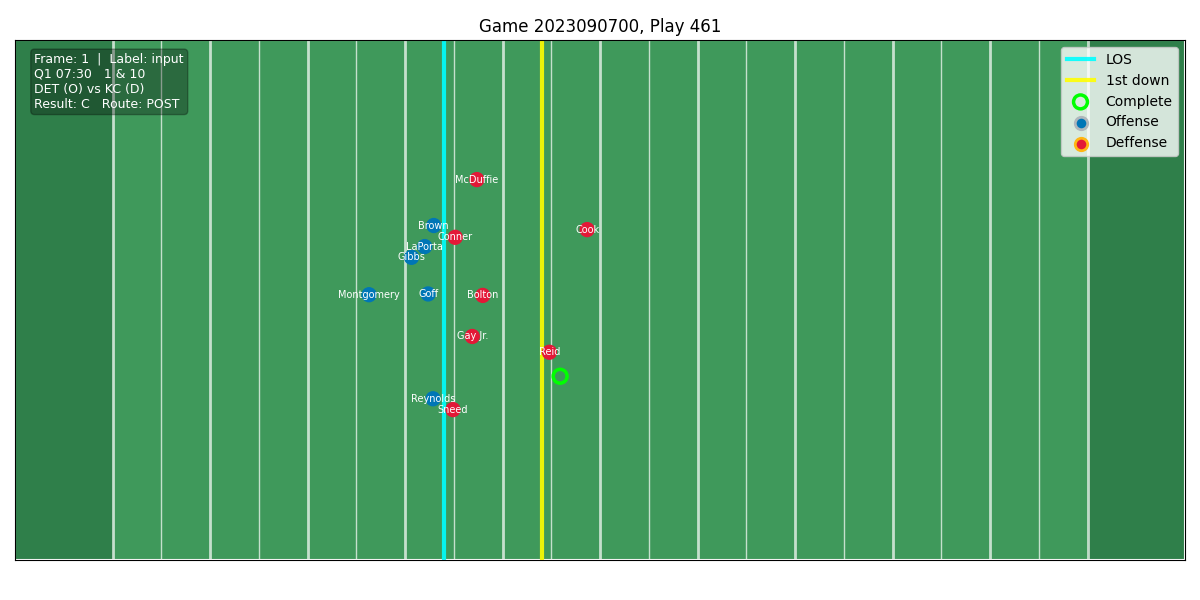

In [10]:
plt.clf

i = 2000
g_id = df["game_id"].iloc[i]
p_id = df["play_id"].iloc[i]

anim = animate_play(df, game_id=g_id, play_id=p_id)

In [11]:
anim.save("play_animation.mp4", writer="ffmpeg", fps=10, dpi=150)